
# Import des packages

In [86]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer

import torch
import torchvision
import torch.nn as nn
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import torch.distributions as td

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

device = torch.device("cpu")

# I - Création des fichiers avec les valeurs manquantes

### Paramètres 

In [87]:
valid_size = 0.3 #Proportion du dataset pour la validation
t = [0.5] #Proportion de valeurs manquantes dans le dataset
version = 5 #Nombre de versions créées par proportion de valeurs manquantes

#NE PAS TOUCHER
NA = [str(int(k*100)) for k in t] #Pourcentage valeurs manquantes du fichier

### Import du dataset

Le chemin indique le lieu où se situe le dataset et où seront créés les fichiers avec valeurs manquantes.
Penser à adapter la manière d'uploader la dataset (pd.read_csv, pd.read_table...)

In [88]:
#Dossier contenant le fichier data
chemin = 'C:/Users/maryo/Desktop/a/'

#Nom du dataset
nom_data = 'NONLIN_1000_20'

#Import data
data = pd.read_csv(chemin+'{0}.csv'.format(nom_data), sep = ' ')
column = data.columns

In [84]:
data.head()

,x,y,b,d,e,f,h,i,j,l,m,o,q,s,t,u,v,w,z,zz
0,4.465021,20.486548,34.548455,328.095026,-3.310094,119.911153,-4.142703,0.279908,3.623008,203.229590,4.913507,24.246143,-0.024968,-115.459051,-60.214419,-214698.044856,2.367437e+11,-2.237627e+06,4.409365,18.747678
1,1.291317,1.529802,12.654254,154.352584,-4.583218,440.939013,-4.524553,0.563683,4.085347,205.935444,-4.551320,20.776780,-0.122992,96.645158,26.045978,18348.152732,1.585014e+09,1.665177e+05,22.159018,490.666221
2,-3.905636,15.072878,21.075979,30.563029,-3.765098,200.380736,-4.087288,0.458335,3.892159,204.514873,-4.694101,22.028558,0.106675,105.664639,41.086966,71049.006873,2.428857e+10,6.682830e+05,49.283621,2427.724568
3,4.702688,22.321724,37.103105,357.889415,-0.552159,-0.198240,-2.092473,0.072447,3.159062,200.696568,5.999605,35.871777,0.874107,-212.257331,-53.938002,-154012.561011,1.222099e+11,-1.612862e+06,31.805150,1012.220037
4,-8.309318,68.384956,69.920025,-997.688939,0.645385,0.225987,0.251639,-0.780701,1.007993,190.933278,4.898636,24.098499,-0.101356,-114.608714,15.234013,3767.426375,6.413751e+07,3.187356e+04,49.353162,2434.844286


### Découpage du dataset en train/validation en prenant au hasard des indices

In [89]:
#Decoupage train/validation
rows, cols = data.shape
shuffled_index = np.random.permutation(rows)
train_index = shuffled_index[:int(rows*(1-valid_size))]
valid_index = shuffled_index[int(rows*(1-valid_size)):]

train_data = data.iloc[train_index, :]
valid_data = data.iloc[valid_index, :]

### Standardisation des données avec MinMaxScaler (utilisé dans l'article sur MIDA donc on l'a gardé pour tous)

In [90]:
#Standardization des donnees
scaler = MinMaxScaler()
scaler.fit(train_data)
X_t = scaler.transform(train_data)
X_v = scaler.transform(valid_data)
X_train = pd.DataFrame(scaler.transform(train_data))
X_train.columns = column
X_Valid = pd.DataFrame(scaler.transform(valid_data))
X_Valid.columns = column

### Export des fichiers de référence pour le train et la validation

In [91]:
#Export des fichiers train et validation sous formt csv
X_train.to_csv(chemin+'X_train.csv', index = True)
X_Valid.to_csv(chemin+'X_Valid.csv', index = True)

### Fonction de l'article MIDA qui ajoute des valeurs manquantes selon un mécanisme et une proportion de valeurs manquantes

Cette partie est reprise du code de l'article .... Il est disponible ici :

In [92]:
def missing_method(raw_data, mechanism='mcar', method='uniform', t = t) :
    
    data = raw_data.copy()
    rows, cols = data.shape
    
    # missingness threshold
    t = t
    
    if mechanism == 'mcar' :
    
        if method == 'uniform' :
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where v<=t
            mask = (v<=t)
            data[mask] = 0

        elif method == 'random' :
            # only half of the attributes to have missing value
            missing_cols = np.random.choice(cols, cols//2)
            c = np.zeros(cols, dtype=bool)
            c[missing_cols] = True

            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where v<=t
            mask = (v<=t)*c
            data[mask] = 0

        else :
            print("Error : There are no such method")
            raise
    
    elif mechanism == 'mnar' :
        
        if method == 'uniform' :
            # randomly sample two attributes
            sample_cols = np.random.choice(cols, 2)

            # calculate ther median m1, m2
            m1, m2 = np.median(data[:,sample_cols], axis=0)
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where (v<=t) and (x1 <= m1 or x2 >= m2)
            m1 = data[:,sample_cols[0]] <= m1
            m2 = data[:,sample_cols[1]] >= m2
            m = (m1*m2)[:, np.newaxis]

            mask = m*(v<=t)
            data[mask] = 0

        elif method == 'random' :
            # only half of the attributes to have missing value
            missing_cols = np.random.choice(cols, cols//2)
            c = np.zeros(cols, dtype=bool)
            c[missing_cols] = True

            # randomly sample two attributes
            sample_cols = np.random.choice(cols, 2)

            # calculate ther median m1, m2
            m1, m2 = np.median(data[:,sample_cols], axis=0)
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where (v<=t) and (x1 <= m1 or x2 >= m2)
            m1 = data[:,sample_cols[0]] <= m1
            m2 = data[:,sample_cols[1]] >= m2
            m = (m1*m2)[:, np.newaxis]

            mask = m*(v<=t)*c
            data[mask] = 0

        else :
            print("Error : There is no such method")
            raise
    
    else :
        print("Error : There is no such mechanism")
        raise
        
    return data, mask

### Fonction qui impute la moyenne

In [93]:
def imput_mean(data,mask):
    col = data.shape[1]
    mask_moy = np.invert(mask)
    for m in range(0,col,1):
        column = data.iloc[:,m]
        moy = np.mean(column[mask[:,m]])
        data.iloc[mask_moy[:,m],m] = moy
    return data

### Boucle créant et exportant les fichiers avec valeurs manquantes et les masks associés

Les valeurs manquantes sont imputées par la moyenne afin que les algorithmes d'imputation puissent fonctionner.

In [94]:
z = 0
for prop_NA in t:
    for i in range(1,version+1,1):
        #Ajout de valeurs manquantes

        missed_data, mask = missing_method(X_train, mechanism='mcar', method='uniform', t = prop_NA)
        mask = np.invert(mask)

        missed_valid, mask_valid = missing_method(X_Valid, mechanism='mcar', method='uniform', t = prop_NA)
        mask_valid = np.invert(mask_valid)

        #Imputation des valeurs manquantes par la moyenne

        missed_data = imput_mean(missed_data,mask)
        missed_valid = imput_mean(missed_valid,mask_valid)    

        #Export en csv
        #Index necessaire pour la preparation des données pour les algorithmes de Deep Learning
        missed_data.to_csv(chemin+'missed_data_{0}_v{1}.csv'.format(NA[z], i), index = True)
        mask_export = pd.DataFrame(mask)
        mask_export.to_csv(chemin+'mask_{0}_v{1}.csv'.format(NA[z], i), index = False)    
        mask_export = pd.DataFrame(mask_valid)
        mask_export.to_csv(chemin+'mask_valid_{0}_v{1}.csv'.format(NA[z], i), index = False)
        missed_valid.to_csv(chemin+'missed_valid_{0}_v{1}.csv'.format(NA[z], i), index = True)
        
    z += 1


# II - Optimisation automatique des algorithmes et évaluation des performances

Dans cette partie les algorithmes sont optimisés. On teste pour les différents autoencoders diverses structures (plus ou moins de couches, plus ou moins de noeuds et 2 types de fonctions d'activation) et pour RandomForest divers nombres d'arbres et différents niveaux de profondeur.

### Paramètres

Si cette partie est excécutée indépendemment de la précédente merci d'enlever les '#' de la cellule suivante et de renseigner les champs.

#### Paramètres pour tous les algorithmes

In [95]:
#Dossier contenant le fichier data
#chemin = 'C:/Users/maryo/Desktop/DEEP LEARNING/DATA IMP/CSV_1000_20/'

#Nom du dataset (pour nommer le fichier qui contiendra les resultats)
#nom_data = 'NONLIN_1000_20'

###Pourcentages valeurs manquantes du dataset a parcourir
NA =  [50] 

###Nombre de versions par fichier
version = 5

###Les versions de fichier pour chaque % de NA a parcourir. Ex: [1,2,3,4,5] par defaut
versions = [k for k in range(1,version+1)]

###Nombre de fois où on répète une combinaison complète (pour voir la stabilité). Au minimum 2
rep = 3

###Algorithmes testes
###Noms des differents algorithmes: 
#       - MIDA :
#       - SDAI spt/pt: sans pre-training (spt) ou avec (pt)
#       - RF : RandomForest
#       - mean : imputation par la moyenne
article = ['MIDA','MIWAE','mean','SDAI pt','SDAI spt','RF']


#### Paramètres pour MIWAE (Variational AutoEncoder)

In [96]:
###Taille des bachs
bs  = 50 

### Nombre d'epochs
n_epochs = 50

### Dimension de l'espace latent
d = 10  

#The intrinsic dimension d is fixed to 10, which may be larger
#than the actual number of features in the data, but DLVMs
#are known to automatically ignore some latent dimensions

### Nombre de IS durant le training
K = 20 

### Nombre de noeuds dans chaque couche interne (ce nombre est fixe pour toutes les couches). 
### Encoder et decoder sont des multi-layer perceptrons avec 3 hidden layers
units=[8,16,32,64,128,256,512] 


#### Paramètres pour MIDA, SDAI pt/spt (Denoising AutoEncoders)

In [97]:
###Taille des bachs
batch_size = 32

###Nombre d'epochs pour le pre training
num_epochs_pt = 10 

###Nombre d'epochs pour le fine tuning
num_epochs_ft = 40 

###Structures a tester pour chaque autoencoder. 
#Ex pour MIDA: [15,20] = couche d'entree -> couche de 15 noeuds -> couche latente de 20 noeuds -> couche de 15 noeuds -> couche de sortie
#Ex pour SDAI: [8, 4] = couche d'entree -> couche de 8 noeuds -> couche de 4 noeuds -> couche de 4 noeuds -> couche de 8 noeuds -> couche de sortie
layers = {'MIDA':[[15, 20], [15, 25], [15, 30], [15, 18, 20], [15, 20, 25],
       [15, 20, 30], [15, 20, 35], [15, 20, 25, 30],
       [15, 20, 30, 40]],
          'SDAI pt':[[8, 4], [8, 2], [8, 6], [8, 6, 4], [8, 5, 2],
       [8, 6, 4, 2]],
          'SDAI spt':[[8, 4], [8, 2], [8, 6], [8, 6, 4], [8, 5, 2],
       [8, 6, 4, 2]] 
}

###Fonctions d'activation testees
activ = ['relu','tanh']

###Fonction d'activation de la couche de sortie 
output_activ = 'sigmoid' 

###Taux de chemins coupes. Fixe ici dans notre etude mais possibilite de le changer a loisir.                    
dropout_rate = 0.5 

###Optimizer
opt = tf.keras.optimizers.Adam(0.01)


### Ecriture du fichier qui contiendra tous les resultats

Les informations recueillies sont les suivantes: \
**Algorithme** : nom de l'algorithme \
**Pourcent_NA** : pourcentage de valeurs manquantes du fichier utilisé \
**Version** : pour le pourcentage de valeurs manquantes ci-dessus quelle version est utilisée (1 à 5 avec les paramètres par défaut) \
**Couches** : structure de l'algorithme \
**Activation** : fonction d'activation utilisée pour les couches internes \
**RMSE** : valeur du RMSE \
**Loss** : liste contenant la valeur moyenne de la fonction de perte pour chaque epoch réalisée sur la partie train \
**Validation_loss** :  liste contenant la valeur moyenne de la fonction de perte pour chaque epoch réalisée sur la partie validation \
\
<font color=red>ATTENTION: la cellule suivante écrase le fichier précédent si celui-ci existe déjà dans le dossier. Mettre 'a' au lieu de 'w' si le but est d'ajouter des lignes.</font>

In [75]:
with open(chemin + 'Resultats_{}.csv'.format(nom_data), 'w', newline='') as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(['Algorithme','Pourcent_NA','Version','Couches','Activation','RMSE','Loss','Validation_loss'])

### Calcul du nombre de variables dans le dataset, nécessaire par la suite pour la création des couches des autoencoders 

In [98]:
columns_name = pd.read_csv(chemin+'X_train.csv'.format(NA), sep =',')
columns_name = columns_name.columns

nb_var = len(columns_name)-1

### Fonctions pour les denoising autoencoders 

In [99]:
###Fonction necessaire pour la preparation des donnees dans le cas d'un autoencoder. 
###Elle provient de la doc de TensorFlow, disponible ici : https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
def pack_features_vector(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

###Classe transposant les poids (pour SDAI qui a des Tied Weights). Cette fonction est celle cree par Aurelien Geron 
###et disponible ici: https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
        shape=[self.dense.input_shape[-1]],
        initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

###Fonction creant les couches de SDAI spt
def layers_AE(layers_dense, activ):
    dense = []
    for i, j  in zip(layers_dense,[activ]*len(layers_dense)):
        dense.append(keras.layers.Dense(i, activation = j))
    return dense

###Fonction qui realise le pre training d'une paire de couches
def pre_train_layer(X_train, X_valid, loss, optimizer, dense, n_epochs=10, output_activation=None, metrics=None, num_layer = 0):
    
    n_inputs = X_train.shape[1]
    dense_init = keras.layers.Input(shape=[n_inputs])
    
    encoder = keras.models.Sequential([
        dense[num_layer],
    ])
    
    decoder = keras.models.Sequential([
        DenseTranspose(dense[num_layer], activation = output_activation),
    ])
    
    autoencoder = keras.models.Sequential([dense_init,encoder, decoder])
    
    if num_layer == 0:
      train_all(autoencoder, n_epochs, opt, mask)
    else:
      autoencoder.compile(optimizer, loss = loss , metrics=metrics)
      autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=[X_valid, X_valid])
        
    return encoder, decoder, encoder(X_train), encoder(X_valid)

###Fonction realisant le pre-training complet
def pre_training(X_t, X_v, num_epochs_pt, output_activ, layers_dense, activ):
    enc_list = []
    dec_list = []
    dense = layers_AE(layers_dense, activ)
    enc, dec, X_t, X_v = pre_train_layer(X_t, X_v, loss = loss_custom, optimizer = opt, dense = dense, output_activation = output_activ, num_layer = 0, n_epochs=num_epochs_pt)
    enc_list.append(enc)
    dec_list.append(dec)
    
    for n in range(1,len(layers_dense),1):
        enc, dec, X_t, X_v = pre_train_layer(X_t, X_v, loss= loss_custom, optimizer = opt, dense = dense, output_activation = factiv, num_layer = n, n_epochs=num_epochs_pt)
        enc_list.append(enc)
        dec_list.append(dec)
        
    return enc_list, dec_list, dense

###Fonction de perte custom pour le pre-training de SDAI pt
def loss_custom(targets, outputs):
    loss = tf.sqrt(tf.reduce_mean(tf.square(targets - outputs)))
    return loss

###Fonction permettant la realisation d'une etape de training
def train_step(net, example, validation, optimizer, mask_b):
  with tf.GradientTape() as tape:
    output = net(example)
    output_valid = net(validation)
    loss_val = tf.sqrt(tf.reduce_mean(tf.square(output_valid - validation)))
    loss = tf.sqrt(tf.reduce_mean(tf.square(output - example)[mask_b]))
  variables = net.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return loss, loss_val

###Fonction qui realise le training complet 
def train_all(net,nb_epochs, opt, mask):
  loss_epochs = []
  loss_val_epochs = []
  epoch = 1
  mean = 1
  while epoch<=nb_epochs and mean>0.0005:###parcours des epochs   
    loss_batch = []
    loss_val_batch = []
    i = 0
    for m, v in zip(miss_dataset,valid_dataset):###parcours des batchs
        example = m[0]
        inf = i * batch_size
        sup = inf + m[0].shape[0]
        mask_b = mask[inf:sup,:]
        validation = v[0]
        lb, lvb = train_step(net, example, validation, opt, mask_b)
        loss_batch.append(lb)
        loss_val_batch.append(lvb)
        i = i + 1
    loss_epochs.append(np.mean(loss_batch))
    loss_val_epochs.append(np.mean(loss_val_batch))
    #print("Epoch {0}/{1}: Loss {2}".format(epoch,nb_epochs,loss_epochs[-1])) 
    if epoch <4:
        mean = 1
    else:
        v = loss_epochs[len(loss_epochs)-4:]
        mean = np.mean([v[0]-v[1], v[1]-v[2], v[2]-v[3]])
        
    epoch = epoch + 1
  return  (loss_epochs, loss_val_epochs)

### Fonctions pour le variational autoencoder (MIWAE)

In [100]:
# On construit maintenant la fonction de  perte de l'algo MIWAE
# Le principe est détaillé dans l'article section 2.2 equation (4)

def miwae_loss(iota_x,mask):
  batch_size = iota_x.shape[0]
  out_encoder = encoder(iota_x)
  q_zgivenxobs = td.Independent(td.Normal(loc=out_encoder[..., :d],scale=torch.nn.Softplus()(out_encoder[..., d:(2*d)])),1)

  zgivenx = q_zgivenxobs.rsample([K])
  zgivenx_flat = zgivenx.reshape([K*batch_size,d])

  out_decoder = decoder(zgivenx_flat)
  all_means_obs_model = out_decoder[..., :nb_var]
  all_scales_obs_model = torch.nn.Softplus()(out_decoder[..., nb_var:(2*nb_var)]) + 0.001
  all_degfreedom_obs_model = torch.nn.Softplus()(out_decoder[..., (2*nb_var):(3*nb_var)]) + 3

  data_flat = torch.Tensor.repeat(iota_x,[K,1]).reshape([-1,1])
  tiledmask = torch.Tensor.repeat(mask,[K,1])

  all_log_pxgivenz_flat = torch.distributions.StudentT(loc=all_means_obs_model.reshape([-1,1]),scale=all_scales_obs_model.reshape([-1,1]),df=all_degfreedom_obs_model.reshape([-1,1])).log_prob(data_flat)
  all_log_pxgivenz = all_log_pxgivenz_flat.reshape([K*batch_size,nb_var])

  logpxobsgivenz = torch.sum(all_log_pxgivenz*tiledmask,1).reshape([K,batch_size])
  logpz = p_z.log_prob(zgivenx)
  logq = q_zgivenxobs.log_prob(zgivenx)

  neg_bound = -torch.mean(torch.logsumexp(logpxobsgivenz + logpz - logq,0))

  return neg_bound

# Le principe d'imputation des VAE est d'avoir une bonne approximation de pθ(z|xo)(ici grace a qγ(z|xo) qui mene a la loss function)
# Cherchons d'abord l'imputation generee proche de la valeur reelle du dataset 
def miwae_impute(iota_x,mask,L):
  batch_size = iota_x.shape[0]
  out_encoder = encoder(iota_x)
  q_zgivenxobs = td.Independent(td.Normal(loc=out_encoder[..., :d],scale=torch.nn.Softplus()(out_encoder[..., d:(2*d)])),1)

  zgivenx = q_zgivenxobs.rsample([L])
  zgivenx_flat = zgivenx.reshape([L*batch_size,d])

  out_decoder = decoder(zgivenx_flat)
  all_means_obs_model = out_decoder[..., :nb_var]
  all_scales_obs_model = torch.nn.Softplus()(out_decoder[..., nb_var:(2*nb_var)]) + 0.001
  all_degfreedom_obs_model = torch.nn.Softplus()(out_decoder[..., (2*nb_var):(3*nb_var)]) + 3

  data_flat = torch.Tensor.repeat(iota_x,[L,1]).reshape([-1,1]).to(device)
  tiledmask = torch.Tensor.repeat(mask,[L,1]).to(device)

  all_log_pxgivenz_flat = torch.distributions.StudentT(loc=all_means_obs_model.reshape([-1,1]),scale=all_scales_obs_model.reshape([-1,1]),df=all_degfreedom_obs_model.reshape([-1,1])).log_prob(data_flat)
  all_log_pxgivenz = all_log_pxgivenz_flat.reshape([L*batch_size,nb_var])

  logpxobsgivenz = torch.sum(all_log_pxgivenz*tiledmask,1).reshape([L,batch_size])
  logpz = p_z.log_prob(zgivenx)
  logq = q_zgivenxobs.log_prob(zgivenx)

  xgivenz = td.Independent(td.StudentT(loc=all_means_obs_model, scale=all_scales_obs_model, df=all_degfreedom_obs_model),1)

  imp_weights = torch.nn.functional.softmax(logpxobsgivenz + logpz - logq,0) # these are w_1,....,w_L for all observations in the batch
  xms = xgivenz.sample().reshape([L,batch_size,nb_var])
  xm=torch.einsum('ki,kij->ij', imp_weights, xms) 

  return xm


# Training
def weights_init(layer):
  if type(layer) == nn.Linear: torch.nn.init.orthogonal_(layer.weight)

# RMSE, indicateur de performance et de similitude pour les imputations
def rmse(xhat,xtrue,mask): 
    xhat = np.array(xhat)
    xtrue = np.array(xtrue)
    return np.sqrt(np.mean(np.power(xhat-xtrue,2)[~mask]))

### Parcours des algorithmes

In [101]:
###Parcours des algorithmes
for art in article: 
    ###Parcours des % de valeurs manquantes
    for val in NA:
        ###Parcours des versions (1 a 5 par defaut) par % de valeurs manquantes
        for vers in versions:   
                  
            mask = pd.read_csv(chemin+'mask_{0}_v{1}.csv'.format(val,vers))
            mask = np.array(mask)
            
            missed_data = pd.read_csv(chemin+'missed_data_{0}_v{1}.csv'.format(val,vers), index_col = 0)
            missed_data = np.array(missed_data)    
            xhat_0 = np.copy(missed_data)
            n = missed_data.shape[0]
            
            mask_valid = pd.read_csv(chemin+'mask_valid_{0}_v{1}.csv'.format(val,vers))
            mask_valid = np.array(mask_valid)
            
            missed_valid = pd.read_csv(chemin+'missed_valid_{0}_v{1}.csv'.format(val,vers), index_col = 0)
            missed_valid = np.array(missed_valid)
            
            X_valid = pd.read_csv(chemin+'X_valid.csv', index_col = 0)
            X_valid = np.array(X_valid)
            
            X_train = pd.read_csv(chemin+'X_train.csv', index_col = 0)
            X_train = np.array(X_train)
                  
            if art not in ['RF','mean','MIWAE']:
                ###Preparation des donnees pour les denoising autoencoders 
                
                #####################################Dataset avec valeurs manquantes tensorflow
                miss_dataset = tf.data.experimental.make_csv_dataset(
                        chemin+'missed_data_{}_v{}.csv'.format(val,vers),
                        batch_size,
                        column_names=columns_name,
                        label_name='Unnamed: 0',
                        shuffle = False,
                        num_epochs=1)
                
                miss_dataset = miss_dataset.map(pack_features_vector)
                features_miss, labels_miss = next(iter(miss_dataset))
                
                #####################################Dataset de reference tensorflow
                train_dataset = tf.data.experimental.make_csv_dataset(
                        chemin+'X_train.csv',
                        batch_size,
                        column_names=columns_name,
                        label_name='Unnamed: 0',
                        shuffle = False,
                        num_epochs=1)
                
                train_dataset = train_dataset.map(pack_features_vector)
                features_train, labels_train = next(iter(train_dataset))
                
                #####################################Dataset valid tensorflow
                if int(mask.shape[0]/batch_size)==mask.shape[0]/batch_size:
                    num_b = int(mask.shape[0]/batch_size)
                else:
                    num_b = int(mask.shape[0]/batch_size) + 1
                    
                valid_dataset = tf.data.experimental.make_csv_dataset(
                        chemin+'X_Valid.csv',
                        num_b,
                        column_names=columns_name,
                        label_name='Unnamed: 0',
                        shuffle = False,
                        num_epochs=1)
                
                valid_dataset = valid_dataset.map(pack_features_vector)
                features_valid, labels_valid = next(iter(valid_dataset))
            
            
                for layers_dense in layers[art]:
                    print('###################################Pourcentage NA:',val)
                    print('###################################Version:',vers)
                    print('###################################Layers:',layers_dense)
                    for factiv in activ:
                        for repet in range(rep):
                            ###Chaque if/elif/else cree le modele associe
                            if art == 'SDAI pt' :
                                ###el pour les couches de l'encoder et dl pour celles du decoder
                                el, dl, dense = pre_training(missed_data, X_valid, num_epochs_pt, output_activ, layers_dense, factiv)
                                NaN_sdae = keras.models.Sequential()
                                NaN_sdae.add(keras.layers.Input(shape=[nb_var]))
                                for k in range(0,len(dense),1):
                                    NaN_sdae.add(keras.layers.Dropout(dropout_rate))
                                    NaN_sdae.add(el[k])
                                for k in range(0,len(dense),1):
                                    ind = k + 1
                                    NaN_sdae.add(dl[-ind])
                                
                            elif art == 'SDAI spt' :
                                dense = layers_AE(layers_dense, factiv)
                                NaN_sdae = keras.models.Sequential()
                                NaN_sdae.add(keras.layers.Input(shape=[nb_var]))
                                for k in range(0,len(dense),1):
                                    NaN_sdae.add(keras.layers.Dropout(dropout_rate))
                                    NaN_sdae.add(dense[k])
                                for k in range(0,len(dense),1):
                                    ind = k+ 1
                                    if ind != len(dense):
                                        NaN_sdae.add(DenseTranspose(dense[-ind], activation = factiv))
                                    else:
                                        NaN_sdae.add(DenseTranspose(dense[-ind], activation = output_activ))
                            
                            elif art == 'MIDA' :
                                NaN_sdae = keras.models.Sequential()
                                NaN_sdae.add(keras.layers.Input(shape=[nb_var]))
                                for k in range(0,len(layers_dense),1):
                                    NaN_sdae.add(keras.layers.Dropout(dropout_rate))
                                    NaN_sdae.add(keras.layers.Dense(layers_dense[k], activation = factiv))
                                for k in range(0,len(layers_dense)-1,1):
                                    ind = k + 2
                                    NaN_sdae.add(keras.layers.Dense(layers_dense[-ind], activation = factiv))
                                NaN_sdae.add(keras.layers.Dense(nb_var, activation = output_activ))
                            
                            history = train_all(NaN_sdae, num_epochs_ft, opt, mask) 
                            predictions = NaN_sdae(np.array(missed_valid)).numpy()           

                            ###Calcul du RMSE 
                            mask_NA = np.invert(mask_valid)
                            data = missed_valid.copy()
                            data[mask_NA] = predictions[mask_NA]
                            ref = np.array(X_valid)
                            RMSE = np.sqrt(np.mean(np.square((ref[mask_NA]-predictions[mask_NA]))))		
                            print('RMSE: ', RMSE)
                            
                            #Ecriture du resultat dans le fichier csv
                            with open(chemin + 'Resultats_{0}.csv'.format(nom_data), 'a', newline='') as file:
                                writer = csv.writer(file, delimiter = ';')
                                writer.writerow([art,val,vers,layers_dense,factiv,RMSE,history[0],history[1]])
            elif art == 'MIWAE':
                for h in units:
                    for repet in range(rep):
                        print('###################################Pourcentage NA:',val)
                        print('###################################Version:',vers)
                        print('###################################Valeur de hidden units:',h)

                        ### Prior Gaussien 
                        p_z = td.Independent(td.Normal(loc=torch.zeros(d).to(device),scale=torch.ones(d).to(device)),1)

                        ### L'encoder va sortir la moyenne et la diagonale de la matrice de covariance
                        ### On peut remplacer 'ReLU' par 'Tanh'
                        encoder = nn.Sequential(
                            torch.nn.Linear(nb_var, h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h, h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h, 2*d),  
                        )

                        ### Le decoder va sortir la moyenne, le scale, et le nombre de degres de libertes
                        decoder = nn.Sequential(
                            torch.nn.Linear(d, h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h, h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h, 3*nb_var),  
                        )

                        miwae_loss_train=np.array([])
                        rmse_train=np.array([])

                        # Ce sera la matrice de donnees imputees/generees
                        xhat = np.copy(xhat_0) 

                        encoder.apply(weights_init)
                        decoder.apply(weights_init)

                        ###Optimizer
                        optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=1e-3)

                        loss_train = []

                        for ep in range(1,n_epochs):
                          perm = np.random.permutation(n) 
                          batches_data = np.array_split(xhat_0[perm,], n/bs)
                          batches_mask = np.array_split(mask[perm,], n/bs)
                          for it in range(len(batches_data)):
                            optimizer.zero_grad()
                            encoder.zero_grad()
                            decoder.zero_grad()
                            b_data = torch.from_numpy(batches_data[it]).float().to(device)
                            b_mask = torch.from_numpy(batches_mask[it]).float().to(device)
                            loss = miwae_loss(iota_x = b_data,mask = b_mask)
                            loss_train.append(loss)
                            loss.backward()
                            optimizer.step()
                          # Affichage valeur loss function pour chaque epoch
                          #if ep % 1 == 0:
                           # print('Epoch %g' %ep)
                            #print('MIWAE likelihood bound  %g' %(-np.log(K)-miwae_loss(iota_x = torch.from_numpy(xhat_0).float().to(device),mask = torch.from_numpy(mask).float().to(device)).cpu().data.numpy()))     

                        ### On impute les valeurs    
                        missed_valid[~mask_valid] = miwae_impute(iota_x = torch.from_numpy(missed_valid).float().to(device),mask = torch.from_numpy(mask_valid).float().to(device),L=10).cpu().data.numpy()[~mask_valid]
                        err = np.array([rmse(missed_valid,X_valid,mask_valid)])
                        print('RMSE : %g' %err)
                        with open(chemin + 'Resultats_{0}.csv'.format(nom_data), 'a', newline='') as file:
                            writer = csv.writer(file, delimiter = ';')
                            writer.writerow([art,val,vers,[h]*3,'ReLU',err[0],loss_train,'--'])
                
            else:
                print('###################################Pourcentage NA:',val)
                print('###################################Version:',vers)
                layers_dense = '--'
                factiv = '--'
                history = ['--','--']
                if art == 'RF':
                            parameters = {'n_estimators':[5,10,20,30,40,50], 'max_depth': [1,3,5,7,9]}
                            perf = []
                            param = []
                            mask_NA = np.invert(mask)
                            missed_data[mask_NA] = np.nan
                            for A in parameters['n_estimators']:
                                for B in parameters['max_depth']:
                                    missRF = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators = A, max_depth = B))
                                    missRF.fit(missed_data)
                                    res = missRF.transform(missed_data)
                                    data = missed_data.copy()
                                    data[mask_NA] = res[mask_NA]
                                    ref = np.array(X_train)
                                    rmse = np.sqrt(np.mean(np.square((ref[mask_NA]-res[mask_NA]))))
                                    perf.append(rmse)
                                    param.append([A,B])
                            RFimput = IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators = param[np.argmin(perf)][0], max_depth = param[np.argmin(perf)][1]))
                            RFimput.fit(missed_data)
                            test = missed_valid.copy()
                            mask_NA = np.invert(mask_valid)
                            test[mask_NA] = np.nan
                            predictions = RFimput.transform(test)
                        
                elif art == 'mean':
                    predictions = missed_valid
                             
                ###Calcul du RMSE 
                mask_NA = np.invert(mask_valid)
                data = missed_valid.copy()
                data[mask_NA] = predictions[mask_NA]
                ref = np.array(X_valid)
                RMSE = np.sqrt(np.mean(np.square((ref[mask_NA]-predictions[mask_NA]))))
                print('RMSE: ', RMSE)
                
                #Ecriture du resultat dans le fichier csv
                with open(chemin + 'Resultats_{0}.csv'.format(nom_data), 'a', newline='') as file:
                    writer = csv.writer(file,delimiter=';')
                    writer.writerow([art,val,vers,layers_dense,factiv,RMSE,history[0],history[1]])


###################################Pourcentage NA: 50
###################################Version: 1
###################################Layers: [15, 20]


KeyboardInterrupt: 

# III - Plot des résultats

### Plot des résultats d'un algorithme par structure et par % de valeurs manquantes

Si cette partie est utilisée indépendemment des autres, penser à changer 'chemin' et 'nom_data'

C:\Users\maryo\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


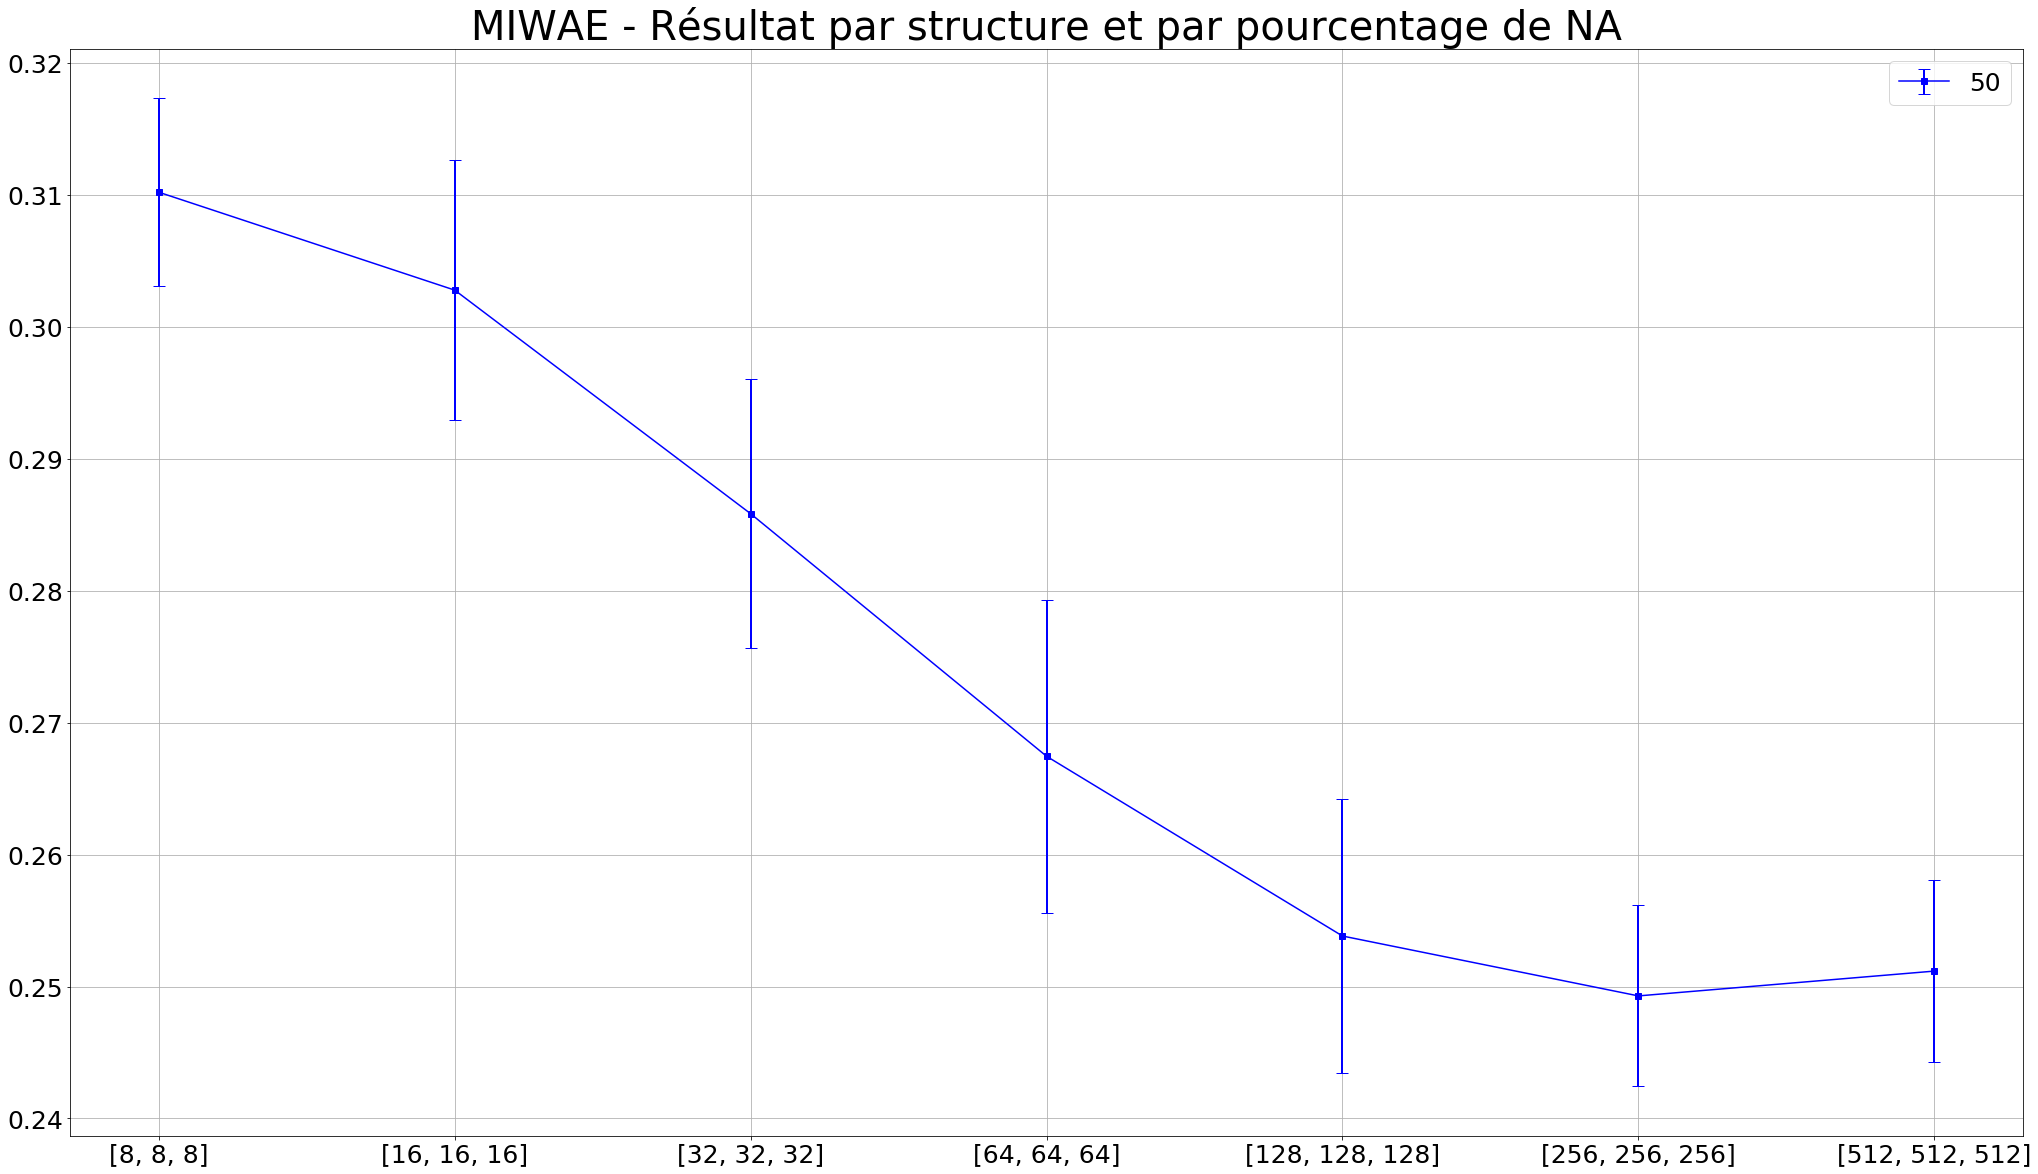

In [102]:
#Parametres
algo = 'MIWAE'
#chemin = 'D:/3A/ProjetI/Non lineaire/4 Resultats 10000 20 OK/'
#nom_data = 'CSV_10000_20_nl'
nom_fichier = 'Resultats_{0}.csv'.format(nom_data)

#Import des resultats
res = pd.read_csv(chemin + nom_fichier, sep=';')

#Data sans mean, RF car pas de structure a etudier
data = res[res['Algorithme']== algo]

#Liste des pourcentages de valeurs manquantes presents dans le csv
NA = list(data['Pourcent_NA'].unique())

#Structures testees associees a l'algo
nb_couches = len(list(data[data['Algorithme']== '{}'.format(algo)].iloc[:,3].unique()))

#Nombre de fonctions d'activation
nb_acti = len(list(data[data['Algorithme']== '{}'.format(algo)].iloc[:,4].unique()))

#Nombre de versions
nb_vers = len(list(data[data['Algorithme']== '{}'.format(algo)].iloc[:,2].unique()))

#Nombre de repetition pour une même combinaison
gp0 = data.groupby(['Algorithme','Pourcent_NA','Version','Couches','Activation'])
nb_rep = gp0['Activation'].agg(['count']).iloc[0].unique()

#Creation d'un index pour que les couches restent dans l'ordre dans le plot
index = []
for p in range(nb_couches):
    index += [p]*nb_rep[0]*nb_acti
index = index*len(NA)*nb_vers


data['Tri'] = index


#Synthese dse resultats
gp1 = data.groupby(['Algorithme','Pourcent_NA','Activation','Tri'])
nb_rep_vers = gp1['Version'].agg(['count']).iloc[0].unique()

#Calcul mean et std pour l'algo choisi
res_RMSE = gp1['RMSE'].agg(['mean','std'])
res_algo = res_RMSE.loc['{}'.format(algo)]

#Plot des resultats
c = ['blue','red','green','purple','orange']
fig, ax = plt.subplots(figsize=(35,20))
if algo != 'MIWAE':
    i = 0
    for k in range(0,len(NA)*2,2):
        ax.errorbar(list(data[data['Algorithme']== '{}'.format(algo)].iloc[:,3].unique()),
                          res_algo.iloc[k*nb_couches:(k+1)*nb_couches,0],
                          yerr=1.96*res_algo.iloc[k*nb_couches:(k+1)*nb_couches,1]/np.sqrt(nb_rep_vers), 
                          color = c[i], 
                          label = str(NA[i])+' relu', 
                          marker = 's',
                          capsize = 6,
                          elinewidth = 2)
        eb_tanh = ax.errorbar(list(data[data['Algorithme']== '{}'.format(algo)].iloc[:,3].unique()),
                      res_algo.iloc[(k+1)*nb_couches:(k+2)*nb_couches,0],
                      yerr=1.96*res_algo.iloc[(k+1)*nb_couches:(k+2)*nb_couches,1]/np.sqrt(nb_rep_vers), 
                      color = c[i], 
                      label = str(NA[i])+' tanh', 
                      marker = 's',
                      capsize = 6,
                      elinewidth = 2, 
                      linestyle = 'dashed')
        eb_tanh[-1][0].set_linestyle('--')
        i += 1
else: 
    for k in range(0,len(NA),1):
        ax.errorbar(list(data[data['Algorithme']== '{}'.format(algo)].iloc[:,3].unique()),
                          res_algo.iloc[k*nb_couches:(k+1)*nb_couches,0],
                          yerr=1.96*res_algo.iloc[k*nb_couches:(k+1)*nb_couches,1]/np.sqrt(nb_rep), 
                          color = c[k], 
                          label = str(NA[k]), 
                          marker = 's',
                          capsize = 6,
                          elinewidth = 2)


ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize = 25, loc = 'best')
ax.grid(True)
ax.set_title('{0} - Résultat par structure et par pourcentage de NA'.format(algo),fontsize = 40)

#Sauvegarde du graphe au format png
#fig.savefig(chemin + 'Resultats_{}.png'.format(algo))
fig.savefig(chemin + 'Resultats {0} pour {1}.png'.format(nom_data,algo))


### Plot de synthèse

#### Récupération du RMSE moyen pour la meilleure structure pour chaque combinaison algo/pourcentage de NA/version

In [103]:
#Parametres
chemin = chemin
nom_data = nom_data
nom_fichier = 'Resultats_{0}.csv'.format(nom_data)

#Import des resultats
res = pd.read_csv(chemin + nom_fichier, sep=';')

#Ecriture du fichier avec les meilleurs resultats
with open(chemin + 'Resultats_'+nom_data+'_best.csv', 'w', newline='') as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(['Algorithme','Pourcent_NA','Version','Couches','Activation','RMSE'])
    for a in ['mean','RF']: #mean et RF sont deja optimises donc on peut copier coller les resultats du fichier de base
        for n in res[res['Algorithme']== a].iloc[:,0:6].values:
            writer.writerow(n)

#Data sans mean, RF
data = res[res['Algorithme']!= 'mean']
data = data[data['Algorithme']!= 'RF']

NA, Versions, Algos = list(data['Pourcent_NA'].unique()), list(data['Version'].unique()), list(data['Algorithme'].unique())

#Calcul de la moyenne et de l'ecart-type pour chaque combinaison algo/pourcentage de NA/version/structure/fonction d'activation
gp1 = data.groupby(['Algorithme','Pourcent_NA','Version','Couches','Activation'])
res_RMSE = gp1['RMSE'].agg(['mean','std'])

#Les valeurs sont rangees par RMSE moyen croissant
res_RMSE = res_RMSE.sort_values(['Algorithme','Pourcent_NA','Version','mean'],ascending=True)

#Ecriture du RMSE moyen pour chaque combinaison
for algo in Algos:
    for na in NA:
        for vers in Versions:
            interm = res_RMSE.loc[algo,na,vers]['mean']
            struc_acti = list(interm[interm == interm.min()].index[0])
            rmse = res_RMSE.loc[algo,na,vers,struc_acti[0],struc_acti[1]]['mean']
            with open(chemin + 'Resultats_' + nom_data + '_best.csv', 'a', newline='') as file:
                writer = csv.writer(file,delimiter=';')
                writer.writerow([algo,na,vers,struc_acti[0],struc_acti[1],rmse])
        

In [104]:
#Import des resultats
data = pd.read_csv(chemin + 'Resultats_' + nom_data + '_best.csv', sep=';')

#Nombre de pourcentages de valeurs manquantes
NA = data.iloc[:,1].unique()

#Nombre de versions
vers = len(data.iloc[:,2].unique())

#Synthese des resultats : calcul du RMSE moyen et de l'ecart-type par algorithme et % de donnees manquantes
gb = data.groupby(['Algorithme','Pourcent_NA'])
synth = gb['RMSE'].agg(['mean','std'])

#Export sous format csv de ces resultats
synth.to_csv(chemin + 'Synthese des resultats {}.csv'.format(nom_data), sep = ';') ######## pas dessous

#### Plot du meilleur RMSE moyen pour les combinaisons algo/pourcentage de NA/version

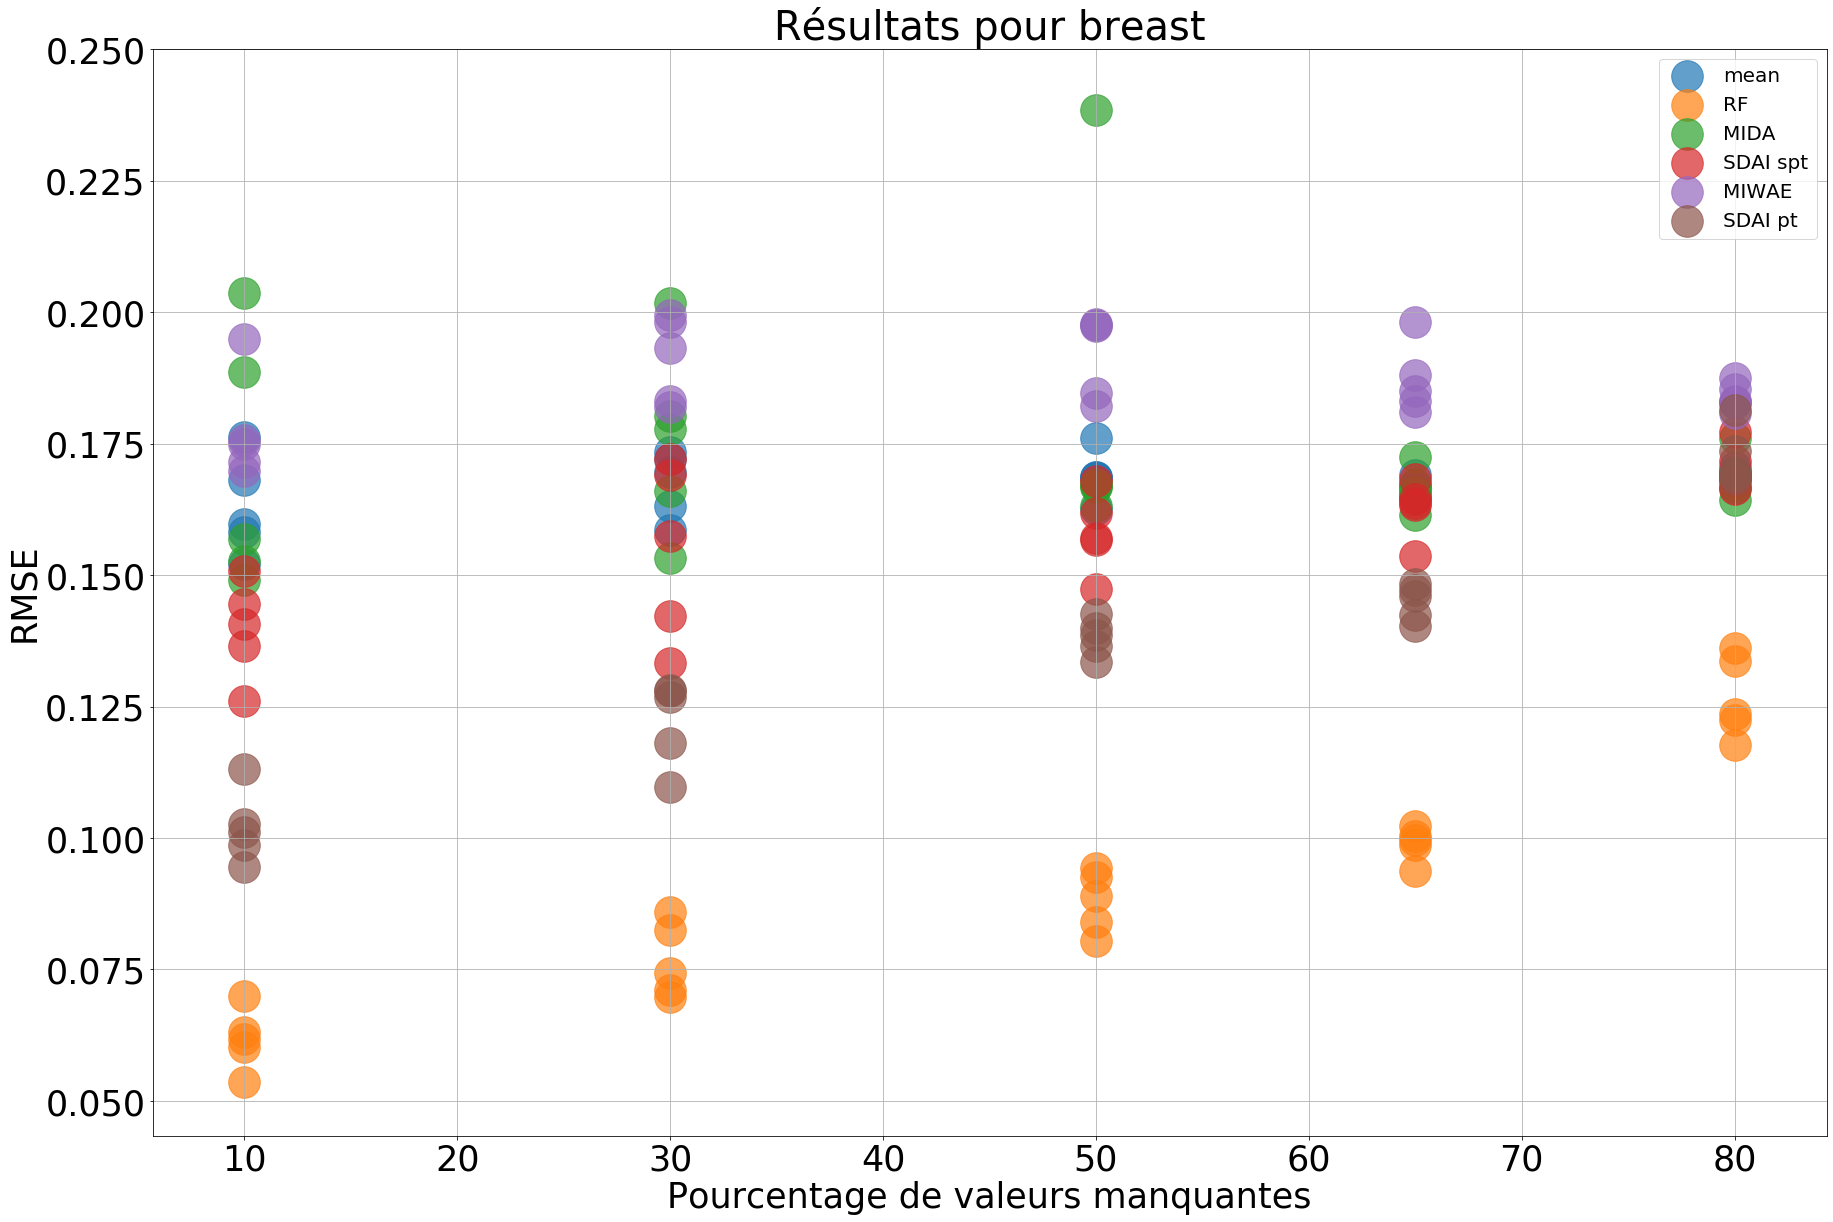

In [42]:
res = pd.read_csv(chemin + 'Resultats_' + nom_data + '_best.csv', sep = ';')
fig, ax = plt.subplots(figsize=(30,20))

compteur = -1
for k in list(res['Algorithme'].unique()):
    compteur += 1
    ax.scatter(res['Pourcent_NA'][res['Algorithme']==k], res['RMSE'][res['Algorithme']==k], s=1000,alpha = 0.7, cmap= 'viridis_r', label = k)


ax.set_title('Résultats pour {}'.format(nom_data), fontsize=40)
ax.set_xlabel('Pourcentage de valeurs manquantes', fontsize=35)
ax.set_ylabel('RMSE', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=35)
ax.legend(fontsize=20)
ax.grid(True)
fig.savefig(chemin + 'Resultats_algos_' + nom_data + '.png')
